## HW 4: Policy gradient
_Reference: based on Practical RL course by YSDA_

In this notebook you have to master Policy gradient Q-learning and apply it to familiar (and not so familiar) RL problems once again.

To get used to `gymnasium` package, please, refer to the [documentation](https://gymnasium.farama.org/introduction/basic_usage/).


In the end of the notebook, please, copy the functions you have implemented to the template file and submit it to the Contest.

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

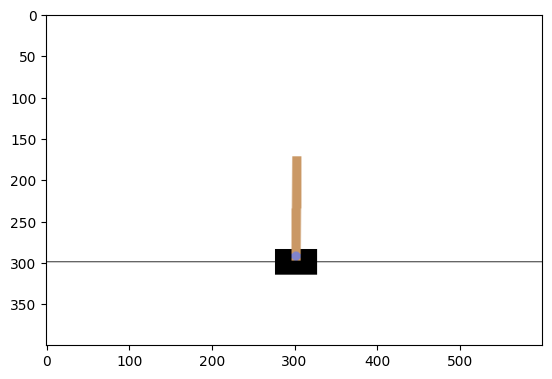

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render())

# Building the network for Policy Gradient (REINFORCE)

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

For numerical stability, please __do not include the softmax layer into your network architecture__.
We'll use softmax or log-softmax where appropriate.

In [3]:
import torch
import torch.nn as nn

In [4]:
# Build a simple neural network that predicts policy logits.
# Keep it simple: CartPole isn't worth deep architectures.
model = None
assert model is not None, "model is not defined"

AssertionError: model is not defined

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Simple policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, n_actions, hidden_size=128):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)  # Do NOT apply softmax here
        return logits

# Instantiate the model
model = PolicyNetwork(state_dim[0], n_actions)


In [6]:
# do not change the code block below
batch_size_for_test = 5
example_states_batch = np.array([env.reset()[0] for _ in range(5)])
print(f"example_states_batch.shape: {example_states_batch.shape}")
assert example_states_batch.shape == (batch_size_for_test, state_dim[0])

example_logits = model(torch.from_numpy(example_states_batch))
print(f"example_logits.shape: {example_logits.shape}")
assert example_logits.shape == (batch_size_for_test, n_actions)
# do not change the code block above

example_states_batch.shape: (5, 4)
example_logits.shape: torch.Size([5, 2])


#### Predicting the action probas

Note: **output value of this function is not a torch tensor, it's a numpy array.**

So, here gradient calculation is not needed.

Use [no_grad](https://pytorch.org/docs/stable/autograd.html#torch.autograd.no_grad)
to suppress gradient calculation.

Also, `.detach()` can be used instead, but there is a difference:

* With `.detach()` computational graph is built but then disconnected from a particular tensor, so `.detach()` should be used if that graph is needed for backprop via some other (not detached) tensor;
* In contrast, no graph is built by any operation in `no_grad()` context, thus it's preferable here.

In [ ]:
def predict_probs(states, model):
    """
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :param model: torch model
    :returns: numpy array of shape [batch, n_actions]
    """
    # convert states, compute logits, use softmax to get probability

    # YOUR CODE GOES HERE
    probs = None
    assert probs is not None, "probs is not defined"

    return probs

In [6]:
# my

import torch
import torch.nn.functional as F

def predict_probs(states, model):
    """
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :param model: torch model
    :returns: numpy array of shape [batch, n_actions]
    """
    states_tensor = torch.from_numpy(states).float()

    with torch.no_grad():  # No gradient calculation
        logits = model(states_tensor)          # [batch, n_actions]
        probs = F.softmax(logits, dim=1).numpy()  # convert to numpy

    assert probs is not None, "probs is not defined"
    return probs


In [7]:
# my 2
def predict_probs(states, model):
    """
    Predict action probabilities given states using a model.
    :param states: numpy array of shape [batch, state_shape]
    :param model: torch model
    :return: numpy array of shape [batch, n_actions]
    """
    states_tensor = torch.from_numpy(states).float()

    with torch.no_grad():
        logits = model(states_tensor)
        probs = torch.softmax(logits, dim=1).numpy()

    return probs

In [8]:
test_states = np.array([env.reset()[0] for _ in range(5)])
test_probas = predict_probs(test_states, model)
assert isinstance(test_probas, np.ndarray), \
    "you must return np array and not %s" % type(test_probas)
assert tuple(test_probas.shape) == (test_states.shape[0], env.action_space.n), \
    "wrong output shape: %s" % np.shape(test_probas)
assert np.allclose(np.sum(test_probas, axis=1), 1), "probabilities do not sum to 1"

In [16]:
print("Predicted probabilities:\n", test_probas)


Predicted probabilities:
 [[0.47153106 0.5284689 ]
 [0.46960354 0.53039646]
 [0.46693683 0.53306323]
 [0.4673471  0.532653  ]
 [0.47119883 0.5288012 ]]


### Play the game

We can now use our newly built agent to play the game.

In [9]:
def generate_session(env, t_max=1000):
    """
    Play a full session with REINFORCE agent.
    Returns sequences of states, actions, and rewards.
    """
    # arrays to record session
    states, actions, rewards = [], [], []
    s, info = env.reset()

    for t in range(t_max):
        # action probabilities array aka pi(a|s)
        action_probs = predict_probs(np.array([s]), model)[0]

        # Sample action with given probabilities.
        a = np.random.choice(n_actions, p=action_probs)
        new_s, r, done, truncated, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    return states, actions, rewards

In [10]:
# test it
states, actions, rewards = generate_session(env)

### Computing cumulative rewards

To work with sequential environments we need the cumulative discounted reward for known for every state. To compute it we can **roll back** from the end of the session to the beginning and compute the discounted cumulative reward as following:

$$
\begin{align*}
G_t &= r_t + \gamma r_{t + 1} + \gamma^2 r_{t + 2} + \ldots \\
&= \sum_{i = t}^T \gamma^{i - t} r_i \\
&= r_t + \gamma * G_{t + 1}
\end{align*}
$$

In [19]:
def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    Take a list of immediate rewards r(s,a) for the whole session
    and compute cumulative returns (a.k.a. G(s,a) in Sutton '16).

    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    A simple way to compute cumulative rewards is to iterate from the last
    to the first timestep and compute G_t = r_t + gamma*G_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    # YOUR CODE GOES HERE
    cumulative_rewards = None
    assert cumulative_rewards is not None, "cumulative_rewards is not defined"

    return cumulative_rewards

In [13]:
# my code
def get_cumulative_rewards(rewards, gamma=0.99):
    """
    Compute discounted cumulative rewards G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...
    :param rewards: list or array of immediate rewards
    :param gamma: discount factor
    :return: numpy array of cumulative rewards
    """
    cumulative_rewards = np.zeros_like(rewards, dtype=np.float32)
    G = 0.0
    for t in reversed(range(len(rewards))):
        G = rewards[t] + gamma * G
        cumulative_rewards[t] = G

    assert cumulative_rewards is not None, "cumulative_rewards is not defined"
    return cumulative_rewards


In [14]:
get_cumulative_rewards(rewards)
assert len(get_cumulative_rewards(list(range(100)))) == 100
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
    [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
    [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0),
    [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum_{s_i,a_i} G(s_i,a_i) $$

REINFORCE defines a way to compute the gradient of the expected reward with respect to policy parameters. The formula is as follows:

$$ \nabla_\theta \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \nabla_\theta \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

We can abuse PyTorch's capabilities for automatic differentiation by defining our objective function as follows:

$$ \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

When you compute the gradient of that function with respect to network weights $\theta$, it will become exactly the policy gradient.

Final loss should also include the entropy regularization term $H(\pi_\theta (a_i \mid s_i))$ to enforce the exploration:

$$
L = -\hat J(\theta) - \lambda H(\pi_\theta (a_i \mid s_i)),
$$
where $\lambda$ is the `entropy_coef`.

This function might be useful:

In [15]:
def to_one_hot(y_tensor, ndims):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    y_one_hot = torch.zeros(
        y_tensor.size()[0], ndims).scatter_(1, y_tensor, 1)
    return y_one_hot

In [16]:
def get_loss(logits, actions, rewards, n_actions=n_actions, gamma=0.99, entropy_coef=1e-2):
    """
    Compute the loss for the REINFORCE algorithm.
    """
    actions = torch.tensor(actions, dtype=torch.int32)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)

    probs = None
    assert probs is not None, "probs is not defined"

    log_probs = None
    assert log_probs is not None, "log_probs is not defined"

    assert all(isinstance(v, torch.Tensor) for v in [logits, probs, log_probs]), \
        "please use compute using torch tensors and don't use predict_probs function"

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    log_probs_for_actions = None # [batch,]
    assert log_probs_for_actions is not None, "log_probs_for_actions is not defined"
    J_hat = None  # a number
    assert J_hat is not None, "J_hat is not defined"

    # Compute loss here. Don't forget entropy regularization with `entropy_coef`
    entropy = None
    assert entropy is not None, "entropy is not defined"
    loss = None
    assert loss is not None, "loss is not defined"

    return loss

In [61]:
#my code
import torch
import torch.nn.functional as F

def get_loss(logits, actions, rewards, n_actions=n_actions, gamma=0.99, entropy_coef=1e-2):
    """
    Compute the REINFORCE loss with optional entropy regularization.

    :param logits: [batch, n_actions] output of the policy network
    :param actions: list or array of taken actions [batch,]
    :param rewards: list or array of rewards [batch,]
    :param gamma: discount factor
    :param entropy_coef: coefficient for entropy regularization
    :return: loss tensor
    """
    # Convert actions and compute cumulative discounted rewards
    actions = torch.tensor(actions, dtype=torch.int64)
    cumulative_returns = torch.tensor(get_cumulative_rewards(rewards, gamma), dtype=torch.float32)
    cumulative_returns = (cumulative_returns - cumulative_returns.mean()) / (cumulative_returns.std() + 1e-8)

    # Compute action probabilities and log-probabilities
    probs = F.softmax(logits, dim=1)        # [batch, n_actions]
    log_probs = F.log_softmax(logits, dim=1)  # [batch, n_actions]

    # Select log-probs for the actions actually taken
    log_probs_for_actions = log_probs[range(len(actions)), actions]  # [batch,]

    # REINFORCE objective (maximize expected return)
    J_hat = log_probs_for_actions * cumulative_returns  # [batch,]

    # Entropy regularization to encourage exploration
    entropy = -torch.sum(probs * log_probs, dim=1)  # [batch,]

    # Final loss (note: we minimize -J_hat)
    loss = -torch.mean(J_hat + entropy_coef * entropy)

    assert all(isinstance(v, torch.Tensor) for v in [logits, probs, log_probs]), \
        "please use compute using torch tensors and don't use predict_probs function"
    assert log_probs_for_actions is not None, "log_probs_for_actions is not defined"
    assert J_hat is not None, "J_hat is not defined"
    assert entropy is not None, "entropy is not defined"
    assert loss is not None, "loss is not defined"

    return loss


In [80]:
#my code 2

def get_loss(logits, actions, rewards, n_actions=n_actions, gamma=0.99, entropy_coef=1e-2):
    """
    Compute REINFORCE loss given logits (policy network output), actions and rewards.
    :param logits: torch tensor [batch, n_actions]
    :param actions: list/array of taken actions [batch,]
    :param rewards: list/array of rewards [batch,]
    :param gamma: discount factor
    :param entropy_coef: entropy regularization coefficient
    :return: torch scalar loss
    """
    actions = torch.tensor(actions, dtype=torch.int64)

    # Cumulative rewards and normalize
    cumulative_returns = torch.tensor(get_cumulative_rewards(rewards, gamma), dtype=torch.float32)
    cumulative_returns = (cumulative_returns - cumulative_returns.mean()) / (cumulative_returns.std() + 1e-8)

    probs = F.softmax(logits, dim=1)
    log_probs = F.log_softmax(logits, dim=1)

    log_probs_for_actions = log_probs[range(len(actions)), actions]  # [batch,]
    J_hat = log_probs_for_actions * cumulative_returns

    entropy = -torch.sum(probs * log_probs, dim=1)  # [batch,]
    loss = -torch.mean(J_hat + entropy_coef * entropy)

    assert all(isinstance(v, torch.Tensor) for v in [logits, probs, log_probs]), \
        "please use compute using torch tensors and don't use predict_probs function"
    assert log_probs_for_actions is not None, "log_probs_for_actions is not defined"
    assert J_hat is not None, "J_hat is not defined"
    assert entropy is not None, "entropy is not defined"
    assert loss is not None, "loss is not defined"

    return loss


In [17]:
#my code 3

def get_loss(logits, actions, rewards, n_actions=n_actions, gamma=0.99, entropy_coef=1e-2):
    # cumulative discounted rewards
    cumulative_returns = torch.tensor(
        get_cumulative_rewards(rewards, gamma), dtype=torch.float32
    )
    cumulative_returns = (cumulative_returns - cumulative_returns.mean()) / (
        cumulative_returns.std() + 1e-8
    )

    # probabilities and log-probabilities
    probs = torch.softmax(logits, dim=1)
    log_probs = torch.log_softmax(logits, dim=1)

    # convert actions to one-hot
    actions = torch.tensor(actions, dtype=torch.int64)
    one_hot_actions = to_one_hot(actions, logits.shape[1])  # [batch, n_actions]

    # log-probs only for chosen actions
    log_probs_for_actions = torch.sum(log_probs * one_hot_actions, dim=1)

    # REINFORCE objective
    J_hat = log_probs_for_actions * cumulative_returns

    # entropy bonus
    entropy = -torch.sum(probs * log_probs, dim=1)

    # final loss (maximize J_hat → minimize -J_hat)
    loss = -torch.mean(J_hat + entropy_coef * entropy)

    return loss

In [26]:
#my code 4

def get_loss(logits, actions, rewards, n_actions=n_actions, gamma=0.99, entropy_coef=1e-2):
    # cumulative discounted rewards
    actions = torch.tensor(actions, dtype=torch.int32)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)

    probs = torch.softmax(logits, dim=1)
    assert probs is not None, "probs is not defined"

    log_probs = torch.log_softmax(logits, dim=1)
    assert log_probs is not None, "log_probs is not defined"

    assert all(isinstance(v, torch.Tensor) for v in [logits, probs, log_probs]), \
        "please use compute using torch tensors and don't use predict_probs function"

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    actions = sourceTensor.detach().clone()
    one_hot_actions = to_one_hot(actions, logits.shape[1])  # [batch, n_actions]
    log_probs_for_actions = torch.sum(log_probs * one_hot_actions, dim=1)
    assert log_probs_for_actions is not None, "log_probs_for_actions is not defined"

    J_hat = log_probs_for_actions * cumulative_returns
    assert J_hat is not None, "J_hat is not defined"

    # Compute loss here. Don't forget entropy regularization with `entropy_coef`
    entropy = torch.sum(probs * log_probs, dim=1)
    assert entropy is not None, "entropy is not defined"

    loss = -torch.mean(J_hat - entropy_coef * entropy)
    assert loss is not None, "loss is not defined"

    return loss

In [21]:
# Your code: define optimizers
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """

    states = torch.tensor(states, dtype=torch.float32)
    logits = model(states)
    # cast everything into torch tensors
    loss = get_loss(logits, actions, rewards, n_actions=n_actions, gamma=gamma, entropy_coef=entropy_coef)
    # Gradient descent step
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # technical: return session rewards to print them later
    return np.sum(rewards)

### The actual training

In [28]:
for i in range(500):
    rewards = [train_on_session(*generate_session(env), entropy_coef=1e-3) for _ in range(100)]  # generate new sessions

    print("mean reward:%.3f" % (np.mean(rewards)))

    if np.mean(rewards) > 800:
        print("You Win!")  # but you can train even further
        break

/tmp/ipython-input-905914556.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actions = torch.tensor(actions, dtype=torch.int32)


mean reward:996.530
You Win!


### Watch the video of your results:

In [64]:
import os
import numpy as np
import gymnasium as gym
from gymnasium.utils.save_video import save_video

env_for_video = gym.make("CartPole-v1", render_mode="rgb_array_list")
n_actions = env_for_video.action_space.n

episode_index = 0
step_starting_index = 0

obs, info = env_for_video.reset()

for step_index in range(800):
    probs = predict_probs(np.array([obs]), model)[0]
    action = np.random.choice(n_actions, p=probs)

    obs, reward, terminated, truncated, info = env_for_video.step(action)
    done = terminated or truncated

    if done or step_index == 799:
        # env_for_video.render() now returns the LIST of frames accumulated so far
        frames = env_for_video.render()
        os.makedirs("videos", exist_ok=True)
        save_video(
            frames, "videos",
            fps=env_for_video.metadata.get("render_fps", 30),
            step_starting_index=step_starting_index,
            episode_index=episode_index,
        )
        episode_index += 1
        step_starting_index = step_index + 1
        obs, info = env_for_video.reset()

env_for_video.close()


Congratulations! Finally, copy the `predict_probs`, `get_cumulative_rewards` and `get_loss` to the template and submit them to the Contest.

Good luck!

## Bonus part (no points, just for the interested ones)

Try solving the `Acrobot-v1` environment. It is more complex than regular `CartPole-v1`, so the default Policy Gradient (REINFORCE) algorithm might not work. Maybe the baseline idea could help...

![Acrobot](https://gymnasium.farama.org/_images/acrobot.gif)


In [ ]:
env = gym.make("Acrobot-v1", render_mode="rgb_array")


env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render())

In [ ]:
# Your brave and victorious code here.